# Overview
This notebook quickly demonstrates my code for computing k1999 without gradient descent
https://www.remi-coulom.fr/Publications/Thesis.pdf#appendix.C

This algorithm was found during research when one groupmate came across https://github.com/cdthompson/deepracer-k1999-race-lines

# Functions
curve is part of the original k1999 code

rotate is not, and is part of "my" solution

I then have two versions of optimize. The first is the vanilla version, and the smooth one is intended to produce more drivable curves.

smooth is similar in intent to the security margins of the linked paper, though I had not read that portion before writing the smooth version of the function.

In [1]:
# Current implementation relies on these three libraries
import numpy
import scipy
import shapely

In [2]:
def curve(points, index):
        numerator = numpy.linalg.det([points[(index+1)%len(points)] - points[index], points[index-1] - points[index]])
            
        denom_a = numpy.linalg.norm(points[(index+1)%len(points)] - points[index])
        denom_b = numpy.linalg.norm(points[index-1] - points[index])
        denom_c = numpy.linalg.norm(points[(index+1)%len(points)] - points[index-1])
        denom = denom_a * denom_b *denom_c
        if denom == 0:
            return 0
        
        return (2 * numerator) / denom

In [3]:
def rotate(p, origin=(0, 0), degrees=0):
    """pulled from https://stackoverflow.com/a/58781388"""
    angle = numpy.deg2rad(degrees)
    R = numpy.array([[numpy.cos(angle), -numpy.sin(angle)],
                  [numpy.sin(angle),  numpy.cos(angle)]])
    o = numpy.atleast_2d(origin)
    p = numpy.atleast_2d(p)
    return numpy.squeeze((R @ (p.T-o.T) + o.T).T)

In [4]:
def optimize(curves, points, track):
    for index in range(len(points)):
        curve_prev = curves[index-1]
        curve_next = curves[(index+1)%len(points)]
        point_prev = points[index-1]
        point_next = points[(index+1)%len(points)]
        point_curr = points[index]
            
        # lazy compute. compute linear midpoint, and then slightly adjust!
        ancor_point = (point_next + point_prev) / 2
        target_curvature = (curve_prev + curve_next) / 2
        new_point = rotate(ancor_point, point_curr, target_curvature)
        
        tries = 0
        while not track.intersects(shapely.Point(new_point)):
            new_point += (points[index] - new_point) / 2
            tries += 1
            if tries > 4:
                new_point = points[index]
                
        points[index] = new_point
        curves[index] = curve(points, index)

In [5]:
def optimize_smooth(curves, points, track, smoothing=0.75):
    for index in range(len(points)):
        curve_prev = curves[index-1]
        curve_next = curves[(index+1)%len(points)]
        curve_curr = curves[index]
        point_prev = points[index-1]
        point_next = points[(index+1)%len(points)]
        point_curr = points[index]
            
        # lazy compute. compute linear midpoint, and then slightly adjust!
        ancor_point = (point_next + point_prev) / 2
        target_curvature = numpy.around((curve_prev + curve_next) / 2, 5)
        
        new_point = rotate(ancor_point, point_curr, target_curvature)
        
        # Computation to attempt to get better curves for actual cars
        if abs(target_curvature) > abs(smoothing):
            new_point += (points[index] - new_point) * smoothing
            new_point = rotate(new_point, ancor_point, -curve_next)
        elif abs(target_curvature) == 0.0:
            new_point += (points[index] - new_point) / smoothing
            new_point = rotate(new_point, ancor_point, -curve_next)
            
        
        tries = 0
        while not track.intersects(shapely.Point(new_point)):
            new_point += (points[index] - new_point) / 2
            tries += 1
            if tries > 4:
                new_point = points[index]
                
        points[index] = new_point
        curves[index] = curve(points, index)

# Understanding of Mechanism
The idea behind this code is to "grab" a point from an anchor and to wobble it back and forth such that over many iterations, it settles into a smooth rolling average of the curve values. This inherently will cause it to optimize out unnecessary geometry.

The one big thing here, is that I am unsure how shapely is computing intersections. I dug a bit through its underlying C++ library, but the documentation of code structure was (per usual) missing.

# Example Usage
Load some track map, and compute its optimal line as a demonstration

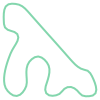

In [6]:
# Fetch some track, and compute on it.
# https://github.com/aws-deepracer-community/deepracer-race-data/tree/main/raw_data/tracks
# is a good source for track data
track_points = numpy.load("2022_reinvent_champ.npy")
line = track_points[:, :2]  # track data from here includes outer and inner lines. Remove them.
shapely.LinearRing(line)

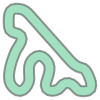

In [7]:
# Generate the track shpae, required for checking if the optimized line is within track bounds
inner_line = track_points[:, 2:4]
outer_line = track_points[:, 4:]

track = shapely.Polygon(outer_line, [inner_line])
track

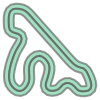

In [8]:
track.difference(shapely.LinearRing(line).buffer(.01)) # show mid-line on track

In [9]:
# Produce pre-requisite curves, which are just the angle from one point to the next
# There is probably *some* limit in which this will work in terms of point spacing,
# though this can be fixed via interpolation
curves = []
        
for index in range(len(line)):
    curves.append(curve(line, index))

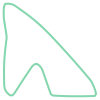

In [10]:
# Build optimal line. I found that 25-30 iterations seems to work best before things get too tight for a car.
opt_line = numpy.copy(line)
for i in range(30):
    optimize(curves, opt_line, track)

shapely.LinearRing(opt_line)  # this actually might be too tight regardless though...

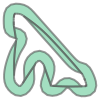

In [11]:
track.difference(shapely.LinearRing(opt_line).buffer(.1e-10))  # really low number to show we haven't gone out of bounds

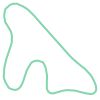

In [12]:
# Build smooth line. I found that 25-30 iterations seems to work best before things get too tight for a car.
smooth_line = numpy.copy(line)
for i in range(10):
    optimize_smooth(curves, smooth_line, track)

shapely.LinearRing(smooth_line)  # feel free to compare against normal optimize call.

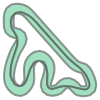

In [13]:
track.difference(shapely.LinearRing(smooth_line).buffer(.1e-10))

# Final Notes
In reading further through the intial paper, it appears the track line computation was rather quick, and that only the publically posted github is very slow. This could potentially implicate that this code is slower than gradient descent, though it would be impossible to for certain to know without comparing two implementations written somewhat optimally in the same language. Though, speed might not matter here in terms of novelty, and my engineering brain is getting the better of me with this thought train.